Your assignment 6 is to take your best 5th code, and run below versions for 25 epochs and report findings:

1.with L1 + BN

2.with L2 + BN

3.with L1 and L2 with BN

4.with GBN

5.with L1 and L2 with GBN


In [1]:
# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.4213)
 - std: tensor(0.0889)
 - var: tensor(0.0079)
torch.Size([128, 1, 28, 28])
torch.Size([128])


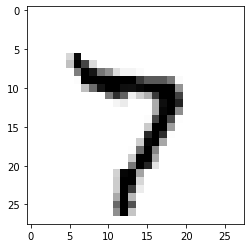

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

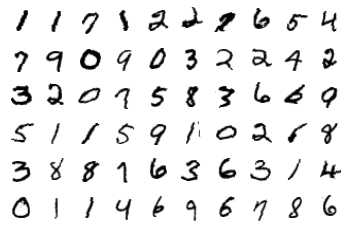

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [8]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [9]:

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [10]:
class GhostNet(nn.Module):
  def __init__(self):
    super(GhostNet,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=12,kernel_size=(3,3),padding = 0, bias = False),
        GhostBatchNorm(12,2),
        nn.ReLU(),
        #nn.Dropout(0.1),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        GhostBatchNorm(18,2),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 18,out_channels = 9,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=9,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        GhostBatchNorm(18,2),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        GhostBatchNorm(18,2),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        GhostBatchNorm(18,2),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=18,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)


In [11]:

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=12,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(12),
        nn.ReLU(),
        #nn.Dropout(0.1),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 18,out_channels = 9,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=9,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.BatchNorm2d(18),
        nn.ReLU(),
        # nn.Dropout(0.1),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=18,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 18, 24, 24]           1,944
       BatchNorm2d-5           [-1, 18, 24, 24]              36
              ReLU-6           [-1, 18, 24, 24]               0
            Conv2d-7            [-1, 9, 24, 24]             162
         MaxPool2d-8            [-1, 9, 12, 12]               0
            Conv2d-9           [-1, 18, 10, 10]           1,458
      BatchNorm2d-10           [-1, 18, 10, 10]              36
             ReLU-11           [-1, 18, 10, 10]               0
           Conv2d-12             [-1, 18, 8, 8]           2,916
      BatchNorm2d-13             [-1, 18, 8, 8]              36
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, epoch,lambda_l1):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # L1 loss
    l1 = 0
    # lambda_l1 = 0.05
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    loss = loss + lambda_l1*l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()




def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
def run_model(model,l1,l2):
  model=model
  l1=l1
  l2=l2
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=l2)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  running_loss=0
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch,lambda_l1=l1)
    scheduler.step()
    test(model, device, test_loader)

In [15]:
#params=[['bn_l1',1e-5,0],['bn_l2',0,1e-5],['bn_l1_l2',1e-5,1e-5],['gbn',0,0],['gbn_l1_l2',1e-5,1e-5]]
params=[['bn_l1',5e-4,0],['bn_l2',0,5e-3],['bn_l1_l2',5e-4,5e-3],['gbn',0,0],['gbn_l1_l2',5e-4,5e-3]]
train_losses_f = []
test_losses_f = []
train_acc_f = []
test_acc_f = []
for i,x in enumerate(params):

  print("\nMODEL",i+1)
  print("Property",x[0]+"\n")
  EPOCHS = 25
  from torch.optim.lr_scheduler import StepLR
  #model =  GhostNet().to(device)
  l1=x[1]
  l2=x[2]
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  model =  Net().to(device)
  if(x[0].startswith('g')):
    model =  GhostNet().to(device)
  run_model(model,l1,l2)
  train_losses_f.extend(train_losses)
  test_losses_f.extend(test_losses)
  train_acc_f.extend(train_acc)
  test_acc_f.extend(test_acc)
  torch.save(model,'./data/'+x[0])
  
  # import seaborn as sns
  # import matplotlib.pyplot as plt
  # sns.set()
  # plt.title(x[0])
  # plt.style.use("dark_background")
  # fig, axs = plt.subplots(2,2,figsize=(15,10))
  # axs[0, 0].plot(train_losses)
  # axs[0, 0].set_title("Training Loss")
  # axs[1, 0].plot(train_acc)
  # axs[1, 0].set_title("Training Accuracy")
  # axs[0, 1].plot(test_losses)
  # axs[0, 1].set_title("Test Loss")
  # axs[1, 1].plot(test_acc)
  # axs[1, 1].set_title("Test Accuracy")
  # print("ITERATION OF A MODEL COMPLETE ")




MODEL 1
Property bn_l1



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.3313341736793518 Batch_id=468 Accuracy=85.50: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1004, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.3427237272262573 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1264, Accuracy: 9627/10000 (96.27%)

EPOCH: 3


Loss=0.24360214173793793 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9851/10000 (98.51%)

EPOCH: 4


Loss=0.22446155548095703 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:26<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.22198878228664398 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9771/10000 (97.71%)

EPOCH: 6


Loss=0.20164230465888977 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9827/10000 (98.27%)

EPOCH: 7


Loss=0.2283262014389038 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.19075915217399597 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.16495847702026367 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.19101539254188538 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.16027045249938965 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.17794185876846313 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.15403275191783905 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.19515101611614227 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.15025010704994202 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.1689678430557251 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.17145031690597534 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.15633398294448853 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.15840643644332886 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.1530170738697052 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.1446944773197174 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.161540687084198 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.14317594468593597 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.14824074506759644 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.15963459014892578 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9947/10000 (99.47%)


MODEL 2
Property bn_l2

EPOCH: 1


Loss=0.28737717866897583 Batch_id=468 Accuracy=84.36: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1627, Accuracy: 9666/10000 (96.66%)

EPOCH: 2


Loss=0.10411134362220764 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:26<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Accuracy: 9784/10000 (97.84%)

EPOCH: 3


Loss=0.08796209841966629 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08005150407552719 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.0625741258263588 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9834/10000 (98.34%)

EPOCH: 6


Loss=0.06624411791563034 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9839/10000 (98.39%)

EPOCH: 7


Loss=0.04676886275410652 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.10440206527709961 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.053923558443784714 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.0515199638903141 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.07341083139181137 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.07649455964565277 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.05451921746134758 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.05320926383137703 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.03994887322187424 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.11711513996124268 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.06590598076581955 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.07164692133665085 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.12074338644742966 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.04984027519822121 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.03461970016360283 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.08499297499656677 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.08189912140369415 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.06139653921127319 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9926/10000 (99.26%)

EPOCH: 25


Loss=0.09256768971681595 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9928/10000 (99.28%)


MODEL 3
Property bn_l1_l2

EPOCH: 1


Loss=0.4120216965675354 Batch_id=468 Accuracy=84.55: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1562, Accuracy: 9668/10000 (96.68%)

EPOCH: 2


Loss=0.2310575693845749 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1193, Accuracy: 9742/10000 (97.42%)

EPOCH: 3


Loss=0.2195376753807068 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 9782/10000 (97.82%)

EPOCH: 4


Loss=0.19849860668182373 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9814/10000 (98.14%)

EPOCH: 5


Loss=0.21282929182052612 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1009, Accuracy: 9830/10000 (98.30%)

EPOCH: 6


Loss=0.20909398794174194 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0976, Accuracy: 9773/10000 (97.73%)

EPOCH: 7


Loss=0.16121405363082886 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.23310691118240356 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.16271302103996277 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.14276961982250214 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.13076689839363098 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.1461963653564453 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.22456376254558563 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.15740691125392914 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.15771254897117615 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.13186237215995789 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.14407238364219666 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.13835550844669342 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.13095073401927948 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.1439235806465149 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.13207246363162994 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.12539909780025482 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.12459761649370193 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.12549886107444763 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.16602292656898499 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9934/10000 (99.34%)


MODEL 4
Property gbn

EPOCH: 1


Loss=0.11638665199279785 Batch_id=468 Accuracy=84.86: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1939, Accuracy: 9456/10000 (94.56%)

EPOCH: 2


Loss=0.0943790152668953 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.018682369962334633 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.06991840153932571 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.03963065519928932 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.059889256954193115 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.03730370104312897 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.018792346119880676 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.020366035401821136 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.03866138681769371 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.02008260041475296 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.01803211122751236 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.03721116855740547 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.02684597671031952 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.028898214921355247 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.0137747498229146 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.016293153166770935 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.044030871242284775 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.018950866535305977 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.012673723511397839 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.04394469037652016 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.006882977206259966 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.055013250559568405 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.02128603868186474 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 25


Loss=0.01685778610408306 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)


MODEL 5
Property gbn_l1_l2

EPOCH: 1


Loss=0.33214718103408813 Batch_id=468 Accuracy=82.52: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1732, Accuracy: 9651/10000 (96.51%)

EPOCH: 2


Loss=0.2735029458999634 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1025, Accuracy: 9788/10000 (97.88%)

EPOCH: 3


Loss=0.22288644313812256 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0982, Accuracy: 9799/10000 (97.99%)

EPOCH: 4


Loss=0.2320786565542221 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0945, Accuracy: 9791/10000 (97.91%)

EPOCH: 5


Loss=0.2458760291337967 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0969, Accuracy: 9819/10000 (98.19%)

EPOCH: 6


Loss=0.2639668881893158 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9779/10000 (97.79%)

EPOCH: 7


Loss=0.1890518069267273 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.20363688468933105 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.1372997760772705 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.2131902128458023 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.17436277866363525 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.15492311120033264 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.12484817206859589 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.14915768802165985 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.14244090020656586 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.1529484987258911 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.13794250786304474 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.16812577843666077 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.17099744081497192 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.15440179407596588 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9925/10000 (99.25%)

EPOCH: 21


Loss=0.13952527940273285 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.109634630382061 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.15346014499664307 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.12784157693386078 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9928/10000 (99.28%)

EPOCH: 25


Loss=0.1304115355014801 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]



Test set: Average loss: 0.0410, Accuracy: 9926/10000 (99.26%)



In [16]:
print(len(train_losses_f))
print(len(test_losses_f ))
print(len(train_acc_f ))
print(len(test_acc_f ))

58625
125
58625
125


In [17]:
#Extract Test Acuracy for each model

len(params)

5

In [18]:
int(len(train_losses_f)/len(params))

11725

In [19]:
#TRAIN ACC
epoch=int(len(train_acc_f)/len(params))
bn_l1_train_acc=train_acc_f[0:epoch]
bn_l2_train_acc=train_acc_f[1*epoch:2*epoch]
bn_l1_l2_train_acc=train_acc_f[2*epoch:3*epoch]
gbn_train_acc=train_acc_f[3*epoch:4*epoch]
gbn_l1_l2_train_acc=train_acc_f[4*epoch:5*epoch]

#TEST ACC
n=int(len(test_acc_f)/len(params))
bn_l1_test_acc=test_acc_f[0:n]
bn_l2_test_acc=test_acc_f[1*n:2*n]
bn_l1_l2_test_acc=test_acc_f[2*n:3*n]
gbn_test_acc=test_acc_f[3*n:4*n]
gbn_l1_l2_test_acc=test_acc_f[4*n:5*n]

#TEST_LOSS
n=int(len(test_losses_f)/len(params))
bn_l1_test_loss=test_losses_f[0:n]
bn_l2_test_loss=test_losses_f[1*n:2*n]
bn_l1_l2_test_loss=test_losses_f[2*n:3*n]
gbn_test_loss=test_losses_f[3*n:4*n]
gbn_l1_l2_test_loss=test_losses_f[4*n:5*n]


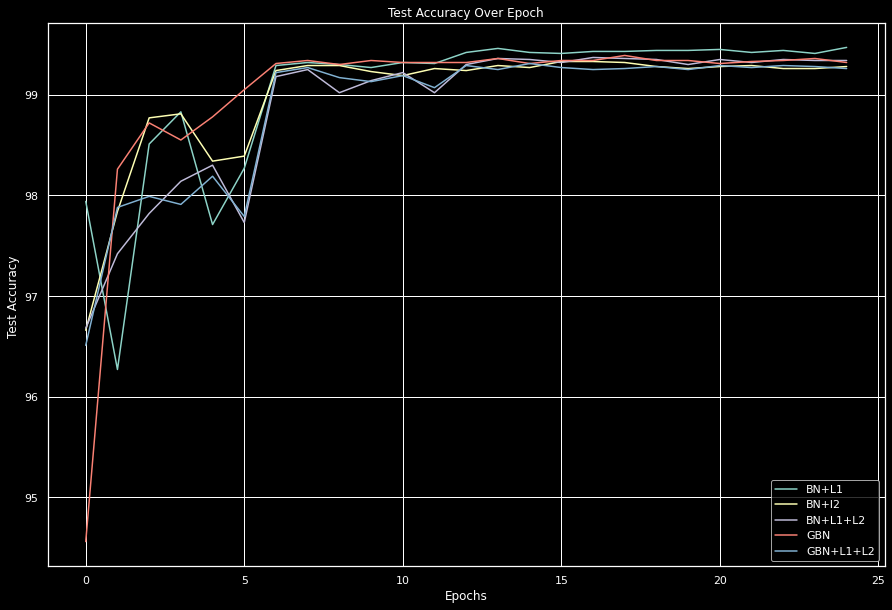

In [20]:
#PLOTTING A GRAPH FOR VALIDATION ACCURACY 


  
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")
plt.figure(figsize=(15,10)) 
plt.plot(bn_l1_test_acc, label='BN+L1')
plt.plot(bn_l2_test_acc, label='BN+l2')
plt.plot(bn_l1_l2_test_acc, label='BN+L1+L2')
plt.plot(gbn_test_acc, label='GBN')
plt.plot(gbn_l1_l2_test_acc, label='GBN+L1+L2')
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy ")
plt.legend(frameon=False)
# Set a title of the current axes.
plt.title('Test Accuracy Over Epoch')
# show a legend on the plot
plt.legend(loc='lower right')


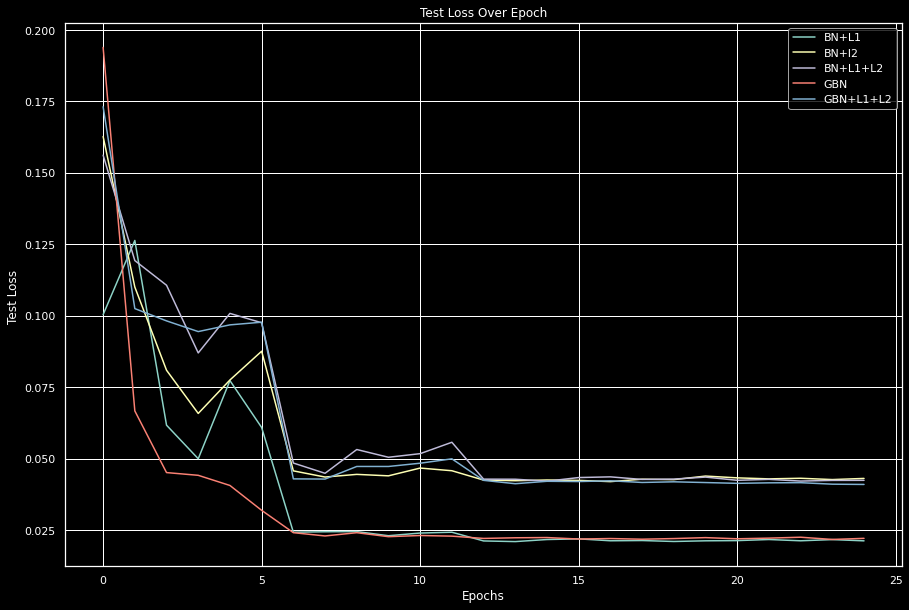

In [21]:
#PLOTTING A GRAPH FOR TEST_LOSS VS EPOCH
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")
plt.figure(figsize=(15,10)) 
plt.plot(bn_l1_test_loss, label='BN+L1')
plt.plot(bn_l2_test_loss, label='BN+l2')
plt.plot(bn_l1_l2_test_loss, label='BN+L1+L2')
plt.plot(gbn_test_loss, label='GBN')
plt.plot(gbn_l1_l2_test_loss, label='GBN+L1+L2')
plt.xlabel("Epochs")
plt.ylabel("Test Loss ")
plt.legend(frameon=False)
# Set a title of the current axes.
plt.title('Test Loss Over Epoch')
# show a legend on the plot
plt.legend(loc='upper right')

In [22]:
#Saving GBN Model
model4 = torch.load('./data/gbn')
model4.eval()

GhostNet(
  (convblock1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GhostBatchNorm(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GhostBatchNorm(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (transitionblock1): Sequential(
    (0): Conv2d(18, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GhostBatchNorm(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GhostBatchNorm(18, eps=1e-05, momentum=0.1, affine=True, tr

In [23]:
import math
def get_misclassified(test_loader, device,model):
        misclassified = []
        misclassified_pred = []
        misclassified_target = []

        # put the model to evaluation mode
        model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in test_loader:
                # move them to the respective device
                data, target = data.to(device), target.to(device)
                # do inferencing
                output = model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_pred = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified

                misclassified.append(batch_misclassified)
                misclassified_pred.append(batch_mis_pred)
                misclassified_target.append(batch_mis_target)

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_pred)
        misclassified_target = torch.cat(misclassified_target)

        return misclassified, misclassified_pred, misclassified_target



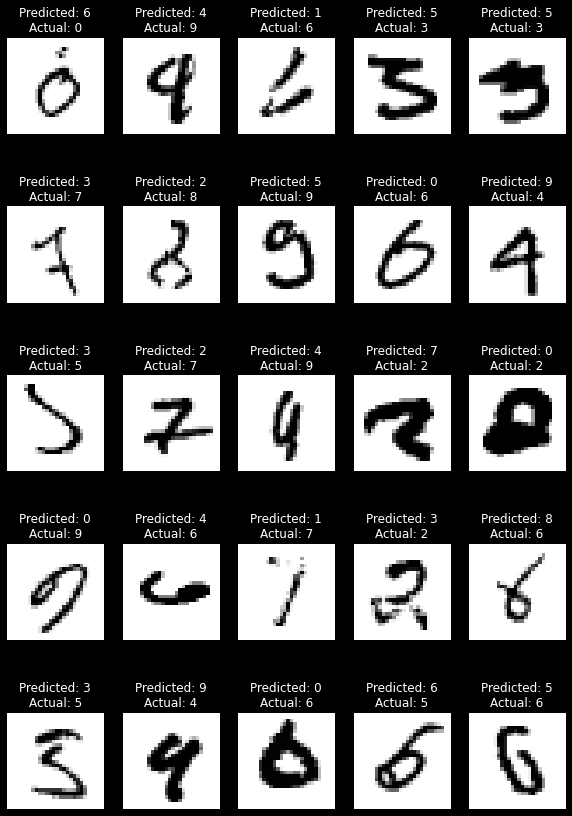

In [24]:
def plot_misclassified(number,test_loader, device,model):
    image_data, predicted, actual = get_misclassified(test_loader, device,model)
    nrows = math.floor(math.sqrt(number))
    ncols = math.ceil(math.sqrt(number))

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 15))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].set_title("Predicted: %d\nActual: %d" % (predicted[index], actual[index]))
            ax[i, j].imshow(image_data[index].cpu().numpy(), cmap="gray_r")



plot_misclassified(25, test_loader, device,model4)